<a href="https://colab.research.google.com/github/yudumpacin/NLPStudyNotes/blob/main/TextClassificationwithTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [51]:
!pip install -q kaggle

In [52]:
!mkdir -p ~/.kaggle

In [53]:
!cp kaggle.json ~/.kaggle

In [54]:

!chmod 600 /root/.kaggle/kaggle.json

In [55]:
!kaggle datasets download -d savasy/ttc4900

ttc4900.zip: Skipping, found more recently modified local copy (use --force to force download)


In [56]:
!unzip /content/ttc4900

Archive:  /content/ttc4900.zip
replace 7allV03.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [57]:
df = pd.read_csv("/content/7allV03.csv")

In [58]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
def preprocess_for_training(text_data):
  text_data = re.sub("[^a-zA-ZğüşöçıİĞÜŞÖÇ0-9.,;:!?'\" ]"," ",text_data)
  text_data = ' '.join([word for word in text_data.split() if word not in stop_words])
  return text_data

In [60]:
df["text"]= df["text"].apply(preprocess_for_training)

In [61]:
df["category"]=df["category"].str.strip()

In [62]:
df["category"]=df["category"].astype("category")

In [63]:
df["category_id"] = df["category"].cat.codes

In [64]:
id_to_category = pd.Series(df.category.values,index=df.category_id).to_dict()
id_to_category

{4: 'siyaset',
 0: 'dunya',
 1: 'ekonomi',
 2: 'kultur',
 3: 'saglik',
 5: 'spor',
 6: 'teknoloji'}

In [65]:
category_to_id= {v:k for k,v in id_to_category.items()}

In [66]:
df["category_id"].shape

(4900,)

In [185]:
X_train,X_test,y_train,y_test = train_test_split(df["text"],df["category_id"], random_state=0,test_size=0.3,stratify=df["category_id"])

In [186]:
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test, random_state=0,test_size=0.5,stratify=y_test)

In [187]:
X_test.shape

(735,)

In [188]:
X_val.shape

(735,)

In [189]:
X_train.shape

(3430,)

In [190]:
y_train.shape

(3430,)

# Simple Transformer

source: https://keras.io/examples/nlp/text_classification_with_transformer/

In [191]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [192]:
#a transformer block as layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [193]:
#Embedding layer
#2 seperate embedding layers, one for token, one for token index(positions)
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [194]:
from keras.callbacks import EarlyStopping


In [195]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
vocab_size = 20000  # Only consider the top 20k words
maxlen = 512  # Only consider the first 512 words of each news

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(7, activation="softmax")(x)

simple_transformer_model = keras.Model(inputs=inputs, outputs=outputs)

In [196]:
# early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    mode='min'
)

In [197]:
simple_transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [198]:
simple_transformer_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512)]             0         
                                                                 
 token_and_position_embeddi  (None, 512, 32)           656384    
 ng_3 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_3 (Trans  (None, 512, 32)           10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_3  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 32)                0   

In [199]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [200]:
import pickle

In [201]:
def preprocess_for_transform(X_train,X_val,X_test):
  # Tokenize and pad the text for training
  tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
  tokenizer.fit_on_texts(X_train)
  #save for later use
  with open("tokenizer.pkl", 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

  X_train_seq = tokenizer.texts_to_sequences(X_train)
  X_test_seq = tokenizer.texts_to_sequences(X_test)
  X_val_seq = tokenizer.texts_to_sequences(X_val)

  X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen)
  X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen)
  X_val_padded = pad_sequences(X_val_seq, maxlen=maxlen)

  return X_train_padded,X_val_padded,X_test_padded


In [202]:
X_train_padded,X_val_padded,X_test_padded = preprocess_for_transform(X_train, X_val, X_test)

In [203]:
X_train_padded

array([[    0,     0,     0, ..., 14649,     1,    54],
       [    0,     0,     0, ...,   516,  7252,     1],
       [    0,     0,     0, ...,    65,   206,  2224],
       ...,
       [    0,     0,     0, ...,   121, 13394,    10],
       [    0,     0,     0, ...,     1,   721,  1056],
       [    0,     0,     0, ...,  9524,  1813,     1]], dtype=int32)

In [204]:
y_train

2864    3
2801    3
1160    0
4009    5
2827    3
       ..
1976    1
4115    5
191     4
4716    6
2650    2
Name: category_id, Length: 3430, dtype: int8

In [205]:
simple_transformer_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [206]:
history_simple_transformer = simple_transformer_model.fit(
    X_train_padded, y_train, batch_size=16, epochs=10, callbacks=[early_stopping],validation_data=(X_val_padded, y_val)
)

Epoch 1/10
215/215 [==============================] - 34s 143ms/step - loss: 1.7836 - accuracy: 0.3029 - val_loss: 1.3164 - val_accuracy: 0.6218
Epoch 2/10
215/215 [==============================] - 21s 99ms/step - loss: 0.6644 - accuracy: 0.7913 - val_loss: 0.4143 - val_accuracy: 0.8626
Epoch 3/10
215/215 [==============================] - 18s 85ms/step - loss: 0.1334 - accuracy: 0.9641 - val_loss: 0.3539 - val_accuracy: 0.8939
Epoch 4/10
215/215 [==============================] - 12s 54ms/step - loss: 0.0353 - accuracy: 0.9942 - val_loss: 0.4111 - val_accuracy: 0.9020
Epoch 5/10
215/215 [==============================] - 11s 52ms/step - loss: 0.0128 - accuracy: 0.9983 - val_loss: 0.4568 - val_accuracy: 0.9088
Epoch 6/10
215/215 [==============================] - 9s 41ms/step - loss: 0.0078 - accuracy: 0.9988 - val_loss: 0.4792 - val_accuracy: 0.9075
Epoch 7/10
215/215 [==============================] - 8s 38ms/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 0.4922 - val_accuracy: 

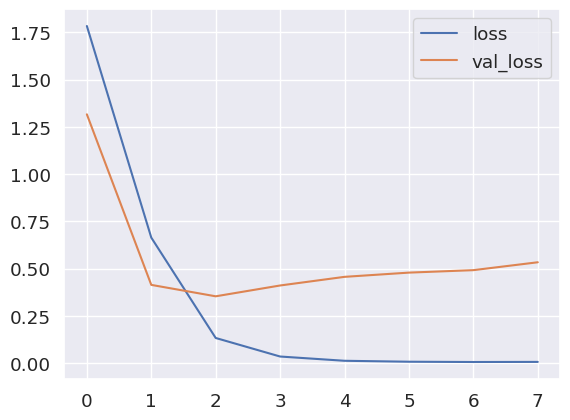

In [207]:
import matplotlib.pyplot as plt
plt.plot(history_simple_transformer.history["loss"], label="loss")
plt.plot(history_simple_transformer.history["val_loss"],label="val_loss")
plt.legend()
plt.show()

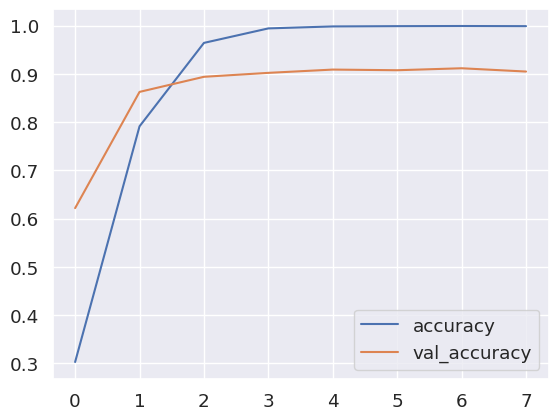

In [208]:
plt.plot(history_simple_transformer.history["accuracy"], label="accuracy")
plt.plot(history_simple_transformer.history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

In [209]:
simple_transformer_model.evaluate(X_test_padded,y_test)

23/23 [==============================] - 0s 8ms/step - loss: 0.6397 - accuracy: 0.8857


[0.6396530866622925, 0.8857142925262451]

In [210]:
id_to_category

{4: 'siyaset',
 0: 'dunya',
 1: 'ekonomi',
 2: 'kultur',
 3: 'saglik',
 5: 'spor',
 6: 'teknoloji'}

In [211]:
from sklearn.metrics import classification_report
y_pred = simple_transformer_model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=1)

23/23 [==============================] - 0s 7ms/step


In [212]:
report = classification_report(y_test, y_pred_labels)


print(report)


              precision    recall  f1-score   support

           0       0.81      0.81      0.81       105
           1       0.88      0.78      0.83       105
           2       0.84      0.93      0.88       105
           3       0.93      0.94      0.93       105
           4       0.86      0.90      0.88       105
           5       1.00      0.94      0.97       105
           6       0.90      0.90      0.90       105

    accuracy                           0.89       735
   macro avg       0.89      0.89      0.89       735
weighted avg       0.89      0.89      0.89       735



In [213]:
id_to_category

{4: 'siyaset',
 0: 'dunya',
 1: 'ekonomi',
 2: 'kultur',
 3: 'saglik',
 5: 'spor',
 6: 'teknoloji'}

In [214]:
targets = list(id_to_category.keys())

In [215]:
report = classification_report(y_test, y_pred_labels,target_names=[id_to_category[i] for i in list(targets)])


print(report)


              precision    recall  f1-score   support

     siyaset       0.81      0.81      0.81       105
       dunya       0.88      0.78      0.83       105
     ekonomi       0.84      0.93      0.88       105
      kultur       0.93      0.94      0.93       105
      saglik       0.86      0.90      0.88       105
        spor       1.00      0.94      0.97       105
   teknoloji       0.90      0.90      0.90       105

    accuracy                           0.89       735
   macro avg       0.89      0.89      0.89       735
weighted avg       0.89      0.89      0.89       735



In [227]:
small_test_data = [
 {"text":"""Son yıllarda internetin en fazla konuşulan kişilerinden olan Bryan Johnson, kendini ölümsüz kılmak amacıyla oluşturduğu akıl almaz
 beslenme ve sağlık rutiniyle gündemden düşmüyor. Kendi bedeni üzerinde yapabileceği deneylerin sonuna gelen Johnson, programını daha fazla kişiye açtı
 ve çok kısa sürede büyük ilgi gördü. Peki bilim insanları ve doktorların eleştiri ve uyarılarına konu olan bu programda ne var?
 Neden tüm uyarılara rağmen Johnson'ın protokolünü bu kadar popüler oldu?""",
 "category":"dunya"},
 {"text":"""Ağız ve diş sağlığının bozulması sonucunda meydana gelen diş kayıpları, konuşma ve kelimeleri telaffuz etmede zorluk yaşattığı gibi sindirim
 sisteminde sorunlara da neden oluyor. Ama hepsi bu değil. Uzmanlara göre dişte oluşan problemler başta kalp rahatsızlıkları olmak üzere akciğer hastalıkları,
  diyabet hatta son araştırmalara göre Alzheimer’ın oluşmasında etkili. Peki dişlerin bu hastalıklarla ilgisi ne? Ağız hijyeni bu sorunların önüne geçmede
  ne kadar etkili?
 Uzmanlarla mercek altına aldık.""",
  "category":"saglik"},
 {"text":"""Bundan yaklaşık 30 yıl önce yapay zekânın hayatımızın her alanına gireceğini, bağışıklık sistemi hücrelerinin kanser tedavisinde
 kilit yöntem olacağını, beyin hücresi atlası çıkarılacağını, gen tedavilerinin yaygınlaşacağını ve uzay turizmi gibi kavramlardan bahsedeceğimizi söyleseler
  bir bilimkurgu filminden bahsedildiğini düşünürdük. Yaşadığımız aşırı doğa olaylarına ve iklim krizine bakarsak da bunun distopik bir film olacağını
  zannederdik. 2023 yılı özellikle sağlık alanındaki bilimsel gelişmeler yönünden verimli ancak doğaya verdiğimiz tahribat açısından umutsuz geçti.
 Peki, 2024’te ve sonraki dönemde bizi neler bekliyor? Bilim insanlarına sorduk.""" ,
 "category":"teknoloji"},
 {"text":"""Trendyol Süper Lig'in 21. haftasında deplasmanda Trabzonspor ile karşılaşacak olan Galatasaray'da kafile açıklandı. Mauro Icardi kadroda yer aldı.
Süper Lig'in 21. haftasında yarın deplasmanda Trabzonspor ile karşı karşıya gelecek olan Galatasaray'da kafile kadrosu belli oldu. İki gündür takımla çalışan Mauro Icardi kadroda yer aldı.""",
  "category":"spor"},
 {"text": """Milyonlarca memur ve emekli maaş zammının yüzde 49.25 olarak belirlenmesinin ardından maaş farklarını beklemeye başladı.
 Memur ve memur emeklileri,
  zamlı maaşlarını ve enflasyon farkları 15 Ocak'tan itibaren alacak.
  """,
  "category":"ekonomi"}

]
test_df = pd.DataFrame(small_test_data)

In [228]:
test_df

,text,category
0,Son yıllarda internetin en fazla konuşulan kiş...,dunya
1,Ağız ve diş sağlığının bozulması sonucunda mey...,saglik
2,Bundan yaklaşık 30 yıl önce yapay zekânın haya...,teknoloji
3,Trendyol Süper Lig'in 21. haftasında deplasman...,spor
4,Milyonlarca memur ve emekli maaş zammının yüzd...,ekonomi


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [229]:
with open("tokenizer.pkl","rb") as tokenizer:
  tokenizer = pickle.load(tokenizer)

In [230]:
import numpy as np

In [231]:
predicted_categories = []

for index, row in test_df.iterrows():
    text = row['text']
    x_seq = tokenizer.texts_to_sequences([text])
    x_padded = pad_sequences(x_seq, maxlen=maxlen)

    prob = simple_transformer_model.predict(x_padded)
    pred = np.argmax(prob, axis=1)[0]
    predicted_category = id_to_category[pred]
    predicted_categories.append(predicted_category)

test_df['predicted_category'] = predicted_categories

1/1 [==============================] - 0s 20ms/step


In [232]:
test_df

,text,category,predicted_category
0,Son yıllarda internetin en fazla konuşulan kiş...,dunya,teknoloji
1,Ağız ve diş sağlığının bozulması sonucunda mey...,saglik,saglik
2,Bundan yaklaşık 30 yıl önce yapay zekânın haya...,teknoloji,saglik
3,Trendyol Süper Lig'in 21. haftasında deplasman...,spor,spor
4,Milyonlarca memur ve emekli maaş zammının yüzd...,ekonomi,ekonomi
